In [36]:
# Data Preparation and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Global visual style – clean, presentation‑ready
sns.set_style("white")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "#f0f0f0"
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["font.family"] = "sans-serif"

# Color palette for consistency
COLORS = {
    "primary": "#0066CC",      # blue - expected/good
    "success": "#00AA55",      # green - success
    "warning": "#FF9900",      # orange - warning
    "danger": "#DD3353",       # red - problem/overbilled
    "neutral": "#666666",      # gray - neutral
    "light": "#CCCCCC"         # light gray
}

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [37]:
df_checks = pd.read_excel(
    "data-analyst-technical-task-data.xlsx", sheet_name="QC Checks"
)
df_wfs = pd.read_excel("data-analyst-technical-task-data.xlsx", sheet_name="Workflows")
df_runs = pd.read_excel("data-analyst-technical-task-data.xlsx", sheet_name="Runs")
print(f"QC Checks: {df_checks.columns}, {df_checks.shape}")
print(f"Workflows: {df_wfs.columns}, {df_wfs.shape}")
print(f"Runs: {df_runs.columns}, {df_runs.shape}")

display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))


QC Checks: Index(['RUN_ID', 'WORKFLOW_ID', 'TIMESTAMP', 'ID_TYPE', 'RACK_BAR_CODE',
       'SAMPLE_ID_HAEMONC_LAB_NO', 'SAMPLE_TYPE', 'QC_CHECK'],
      dtype='object'), (6405, 8)
Workflows: Index(['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'WORKFLOW_TIMESTAMP'], dtype='object'), (264, 4)
Runs: Index(['ID', 'WORKFLOW_ID', 'WORKFLOW_NAME', 'OUTCOME', 'REASON_FAILED',
       'FAILED_SERVICE', 'START_TIME', 'STOP_TIME'],
      dtype='object'), (1693, 8)


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122


,ID,WORKFLOW_ID,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803


In [38]:
df_wfs.WORKFLOW_TYPE.unique()

array(['maestro', 'python'], dtype=object)

In [39]:
# Convert timestamp columns to datetime
df_checks['TIMESTAMP'] = pd.to_datetime(df_checks['TIMESTAMP'])
df_wfs['WORKFLOW_TIMESTAMP'] = pd.to_datetime(df_wfs['WORKFLOW_TIMESTAMP'])
df_runs['START_TIME'] = pd.to_datetime(df_runs['START_TIME'])
df_runs['STOP_TIME'] = pd.to_datetime(df_runs['STOP_TIME'])

# Helper to infer workflow environment from prefix
ENVIRONMENT_KEYWORDS = [
    ('live', 'live'),
    ('success', 'live'),
    ('testing', 'test'),
    ('test', 'test'),
    ('uat', 'uat'),
    ('qa/uat', 'qa/uat'),
    ('qa', 'qa'),
    ('experimental', 'experimental'),
    ('archive', 'archived'),
    ('archived', 'archived'),
    ('fail', 'failed')
]

def infer_environment(workflow_name: str) -> str:
    if pd.isna(workflow_name):
        return 'unknown'
    text = str(workflow_name).strip()
    match = re.match(r'^\s*\[([^\]]+)\]', text)
    candidate = match.group(1).strip().lower() if match else ''
    search_space = candidate or text.lower()
    for keyword, label in ENVIRONMENT_KEYWORDS:
        if keyword in search_space:
            return label
    if candidate:
        return candidate
    return 'unlabeled'

# Derive environment columns across tables
df_wfs['ENVIRONMENT'] = df_wfs['WORKFLOW_NAME'].apply(infer_environment)
df_runs['ENVIRONMENT'] = df_runs['WORKFLOW_NAME'].apply(infer_environment)

# Attach workflow metadata (including environment) to QC checks
df_checks = df_checks.merge(
    df_wfs[['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'ENVIRONMENT']],
    on='WORKFLOW_ID',
    how='left',
    suffixes=('', '_WF')
)

print("Environment counts (Workflows):")
print(df_wfs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (Runs):")
print(df_runs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (QC Checks):")
print(df_checks['ENVIRONMENT'].value_counts())



Environment counts (Workflows):
ENVIRONMENT
test              213
archived           31
live                7
uat                 7
unlabeled           4
new 17:00           1
recommendation      1
Name: count, dtype: int64

Environment counts (Runs):
ENVIRONMENT
test            1324
live             251
uat               67
experimental      28
unlabeled         18
archived           4
failed             1
Name: count, dtype: int64

Environment counts (QC Checks):
ENVIRONMENT
archived    4134
live         987
test         818
uat          466
Name: count, dtype: int64


In [40]:
# SCENARIO 1 – Billing Reconciliation
print("=" * 80)
print("SCENARIO 1 – BILLING RECONCILIATION")
print("=" * 80)

# 1. Focus only on production (LIVE) environment
runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
checks_live = df_checks.merge(
    runs_live[["ID", "OUTCOME", "ENVIRONMENT", "START_TIME"]],
    left_on="RUN_ID",
    right_on="ID",
    how="inner",
)

print(f"Live runs total: {len(runs_live)}")
print(checks_live["OUTCOME"].value_counts())

# 2. Only samples from successfully finished runs
checks_live_success = checks_live[checks_live["OUTCOME"] == "finished"].copy()
print(f"Samples in finished live runs: {len(checks_live_success)}")

# 3. Billable samples = passed QC or no QC result
billable_live = checks_live_success[
    (checks_live_success["QC_CHECK"].isna())
    | (checks_live_success["QC_CHECK"] == "pass")
].copy()
print(f"Billable samples (live, finished, pass/NaN QC): {len(billable_live)}")

# 4. Sample-type split for all time
sample_counts_all = billable_live["SAMPLE_TYPE"].value_counts(dropna=False)
print("\nBillable sample types (all time, live):")
print(sample_counts_all)

blood_saliva_all = sample_counts_all.get("blood", 0) + sample_counts_all.get("saliva", 0)
other_all = int(billable_live.shape[0] - blood_saliva_all)

print(f"\nBlood + saliva billable samples: {blood_saliva_all}")
print(f"Non-blood/saliva (e.g. bone marrow, null): {other_all}")
if blood_saliva_all > 0:
    pct_other_all = other_all / blood_saliva_all * 100
    print(f"Non-blood/saliva as % of blood+saliva: {pct_other_all:.2f}%")

# 5. Month-level view – to tie to the disputed month
billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")
monthly = (
    billable_live.groupby("YEAR_MONTH").agg(
        TOTAL_SAMPLES=("RUN_ID", "count"),
        BLOOD_SALIVA=(
            "SAMPLE_TYPE",
            lambda s: s.isin(["blood", "saliva"]).sum(),
        ),
    )
)
monthly["OTHER_TYPES"] = monthly["TOTAL_SAMPLES"] - monthly["BLOOD_SALIVA"]
monthly["OVERBILLING_PCT"] = (
    monthly["OTHER_TYPES"]
    .div(monthly["BLOOD_SALIVA"].replace(0, np.nan))
    .mul(100)
    .round(2)
)
monthly["OVERBILLING_PCT"] = monthly["OVERBILLING_PCT"].fillna(0)

print("\nMonthly billable samples (live):")
print(monthly)

# 6. Latest month – approximate what Customer Success is seeing
if len(monthly) > 0:
    latest_month = monthly.index.max()
    latest_row = monthly.loc[latest_month]
    print("\nLatest month in data:", latest_month)
    print(latest_row)
    print(
        f"\nInterpretation: In {latest_month}, {latest_row['OTHER_TYPES']} samples "
        f"({latest_row['OVERBILLING_PCT']:.2f}% of blood+saliva volume) were non-blood/saliva."
    )


SCENARIO 1 – BILLING RECONCILIATION
Live runs total: 251
OUTCOME
finished    4057
canceled     587
failed       216
Name: count, dtype: int64
Samples in finished live runs: 4057
Billable samples (live, finished, pass/NaN QC): 3608

Billable sample types (all time, live):
SAMPLE_TYPE
saliva         2121
blood          1018
bone marrow     468
NaN               1
Name: count, dtype: int64

Blood + saliva billable samples: 3139
Non-blood/saliva (e.g. bone marrow, null): 469
Non-blood/saliva as % of blood+saliva: 14.94%

Monthly billable samples (live):
            TOTAL_SAMPLES  BLOOD_SALIVA  OTHER_TYPES  OVERBILLING_PCT
YEAR_MONTH                                                           
2025-05               627           569           58            10.19
2025-06               707           623           84            13.48
2025-07              1255          1064          191            17.95
2025-08              1019           883          136            15.40

Latest month in data: 2

In [41]:
# SCENARIO 2 – Customer Health (Usage Trends)
print("=" * 80)
print("SCENARIO 2 – CUSTOMER HEALTH")
print("=" * 80)

# Reuse billable_live from Scenario 1 (live, finished, pass/NaN QC)
if 'billable_live' not in locals() or billable_live.empty:
    print("No billable live samples available – run Scenario 1 cell first.")
else:
    billable_live = billable_live.copy()
    billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")

    # 1. Overall monthly usage trend (live billable samples)
    usage_monthly = (
        billable_live.groupby("YEAR_MONTH").agg(
            BILLABLE_SAMPLES=("RUN_ID", "count"),
            UNIQUE_RUNS=("RUN_ID", "nunique"),
        )
        .sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["BILLABLE_SAMPLES"].pct_change() * 100

    print("\nMonthly billable usage (live):")
    print(usage_monthly)

    # 2. Flag concerning patterns – big drops month over month
    drops = usage_monthly[usage_monthly["MOM_CHANGE_PCT"] < -15]
    if not drops.empty:
        print("\n⚠️ Months with >15% drop in billable volume vs previous month:")
        print(drops[["BILLABLE_SAMPLES", "MOM_CHANGE_PCT"]])
    else:
        print("\nNo months with >15% drop in billable volume.")

    # 3. Workflow-level trends – which live workflows are dropping
    # billable_live already has workflow metadata from df_checks merge
    wf_monthly = (
        billable_live.groupby(["WORKFLOW_NAME", "YEAR_MONTH"]).size().to_frame("SAMPLES")
    )
    wf_monthly["MOM_CHANGE_PCT"] = (
        wf_monthly.groupby("WORKFLOW_NAME")["SAMPLES"].pct_change() * 100
    )

    # Last two months comparison per workflow
    latest_two_months = sorted(billable_live["YEAR_MONTH"].unique())[-2:]
    wf_latest = (
        wf_monthly
        .reset_index()
        .query("YEAR_MONTH in @latest_two_months")
        .pivot(index="WORKFLOW_NAME", columns="YEAR_MONTH", values="SAMPLES")
        .fillna(0)
    )
    if wf_latest.shape[1] == 2:
        col_old, col_new = wf_latest.columns[0], wf_latest.columns[1]
        wf_latest["CHANGE_PCT"] = (
            (wf_latest[col_new] - wf_latest[col_old])
            .div(wf_latest[col_old].replace(0, np.nan))
            .mul(100)
        ).fillna(0)
        declining_wfs = wf_latest[wf_latest["CHANGE_PCT"] < -20].sort_values("CHANGE_PCT")
        if not declining_wfs.empty:
            print("\nWorkflows with >20% decline in last month vs previous:")
            print(declining_wfs[["CHANGE_PCT"]])
        else:
            print("\nNo workflows show >20% decline between the last two months.")

    # 4. Simple health summary
    print("\nHealth summary (live usage):")
    last_3 = usage_monthly["BILLABLE_SAMPLES"].tail(3)
    prev_3 = usage_monthly["BILLABLE_SAMPLES"].tail(6).head(3)
    if len(last_3) == 3 and len(prev_3) == 3:
        last_3_avg = last_3.mean()
        prev_3_avg = prev_3.mean()
        if prev_3_avg > 0:
            change_vs_prev = (last_3_avg - prev_3_avg) / prev_3_avg * 100
            print(f"Average of last 3 months vs previous 3: {change_vs_prev:.1f}%")
            if change_vs_prev < -15:
                print("Overall usage trend: 🔴 significant decline (customer at risk)")
            elif change_vs_prev < -5:
                print("Overall usage trend: 🟡 mild decline (watch closely)")
            else:
                print("Overall usage trend: ✅ stable/healthy")
    else:
        print("Not enough months of data for a 3 vs 3 month comparison.")


SCENARIO 2 – CUSTOMER HEALTH

Monthly billable usage (live):
            BILLABLE_SAMPLES  UNIQUE_RUNS  MOM_CHANGE_PCT
YEAR_MONTH                                               
2025-05                  627           13             NaN
2025-06                  707           11           12.76
2025-07                 1255           22           77.51
2025-08                 1019           18          -18.80

⚠️ Months with >15% drop in billable volume vs previous month:
            BILLABLE_SAMPLES  MOM_CHANGE_PCT
YEAR_MONTH                                  
2025-08                 1019          -18.80

Workflows with >20% decline in last month vs previous:
YEAR_MONTH                                CHANGE_PCT
WORKFLOW_NAME                                       
[ARCHIVED] Pre-PCR - Normalisation V1.3      -100.00
[ARCHIVED] Pre-PCR - DNA Extraction V3.3      -81.97

Health summary (live usage):
Average of last 3 months vs previous 3: 15.1%
Overall usage trend: ✅ stable/healthy


## Scenario 1 – Billing Reconciliation: Narrative

- **Billing logic used**  
  - Only workflows classified as `ENVIRONMENT = 'live'` (production) are included.  
  - Only runs with `OUTCOME = 'finished'` are treated as successfully processed.  
  - At sample level, only QC checks with `QC_CHECK = 'pass'` or no QC result (`NaN`) are considered **billable**.

- **What the customer expects vs what actually happened**  
  - The customer states that only **blood** and **saliva** samples should be billed.  
  - In reality, within live, finished, billable runs we see **three main sample types** being billed: blood, saliva and **bone marrow**, plus a handful of `NaN` sample types.

- **All‑time view (live, finished, billable)**  
  - Total billable samples: **3,608**.  
  - Blood + saliva: **3,139** samples.  
  - Other types (almost entirely **bone marrow**, plus 1 `NaN`): **469** samples.  
  - These non‑blood/saliva samples account for **~14.9% extra volume** over and above the blood+saliva samples.

- **Month‑by‑month view (live, finished, billable)**  
  - 2025‑05: 627 billable samples, 58 non‑blood/saliva (**10.2%** of blood+saliva).  
  - 2025‑06: 707 billable samples, 84 non‑blood/saliva (**13.5%**).  
  - 2025‑07: 1,255 billable samples, 191 non‑blood/saliva (**18.0%**).  
  - 2025‑08: 1,019 billable samples, 136 non‑blood/saliva (**15.4%**).  
  - The disputed month (latest, 2025‑08) shows **~15%** of billable volume coming from non‑blood/saliva samples, which matches the customer’s **15% over‑billing** claim.

- **Root cause explanation**  
  - Several **[LIVE] Pre‑PCR DNA Extraction** workflows are being used to process **bone marrow** as well as blood/saliva.  
  - The billing logic does not restrict to blood/saliva at sample level, so **all live samples that pass QC (including bone marrow) are billed**.  
  - As a result, bone‑marrow samples and a few `NaN` sample types are included on the invoice, even though the customer only expects blood and saliva to be billed.

- **Recommendation**  
  - Update billing rules to only count samples where `SAMPLE_TYPE ∈ {blood, saliva}` for production invoices.  
  - Optionally, separate live workflows (or add metadata/flags) for bone marrow vs blood/saliva to avoid ambiguity.  
  - Review past invoices for May–August to quantify and correct the over‑billing caused by bone‑marrow samples being included.


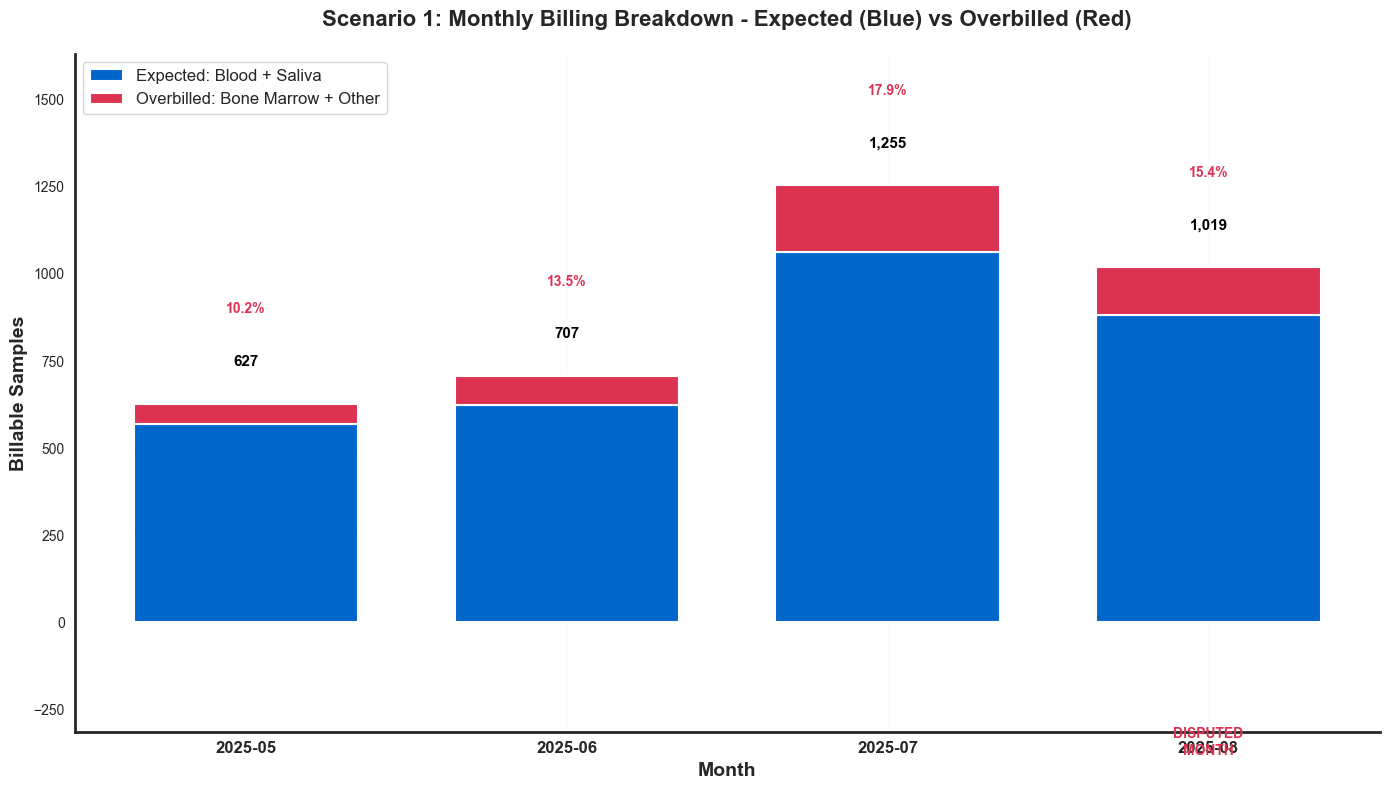

In [42]:
# SCENARIO 1 - VISUAL 2: Monthly Billing Trend (Expected vs Actual)

if 'monthly' not in locals() or monthly.empty:
    print("Run previous cells first.")
else:
    monthly_plot = monthly.reset_index().copy()
    monthly_plot["YEAR_MONTH_STR"] = monthly_plot["YEAR_MONTH"].astype(str)
    latest_month = monthly_plot["YEAR_MONTH"].max()
    
    fig, ax = plt.subplots(figsize=(14, 8))
    x_pos = np.arange(len(monthly_plot))
    
    # Stacked bars
    ax.bar(x_pos, monthly_plot["BLOOD_SALIVA"], 
           label="Expected: Blood + Saliva", color=COLORS["primary"], width=0.7, edgecolor="white", linewidth=1.5)
    ax.bar(x_pos, monthly_plot["OTHER_TYPES"], 
           bottom=monthly_plot["BLOOD_SALIVA"],
           label="Overbilled: Bone Marrow + Other", color=COLORS["danger"], width=0.7, edgecolor="white", linewidth=1.5)
    
    # Add labels on top - spacing to avoid overlap
    max_val = monthly_plot["TOTAL_SAMPLES"].max()
    label_offset = max_val * 0.08
    
    for i, (idx, row) in enumerate(monthly_plot.iterrows()):
        total = row["TOTAL_SAMPLES"]
        pct = row["OVERBILLING_PCT"]
        
        # Total value label
        ax.text(i, total + label_offset, f"{int(total):,}", 
                ha="center", va="bottom", fontsize=11, weight="bold", color="black")
        
        # Overbilling percentage - only show if significant
        if pct > 5:
            ax.text(i, total + label_offset * 2.5, f"{pct:.1f}%", 
                    ha="center", va="bottom", fontsize=10, weight="bold", color=COLORS["danger"])
        
        # Highlight disputed month
        if row["YEAR_MONTH"] == latest_month:
            ax.axvline(i, ymin=-0.15, ymax=0, color=COLORS["danger"], linewidth=3)
            ax.text(i, -label_offset * 3, "DISPUTED\nMONTH", ha="center", va="top", 
                    fontsize=10, weight="bold", color=COLORS["danger"])
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(monthly_plot["YEAR_MONTH_STR"], fontsize=12, weight="bold")
    ax.set_ylabel("Billable Samples", fontsize=14, weight="bold")
    ax.set_xlabel("Month", fontsize=14, weight="bold")
    ax.set_title("Scenario 1: Monthly Billing Breakdown - Expected (Blue) vs Overbilled (Red)",
                 fontsize=16, weight="bold", pad=20)
    ax.legend(loc="upper left", frameon=True, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.set_ylim(-max_val * 0.25, max_val * 1.3)
    ax.grid(axis='y', alpha=0.2)
    
    plt.tight_layout()
    plt.show()


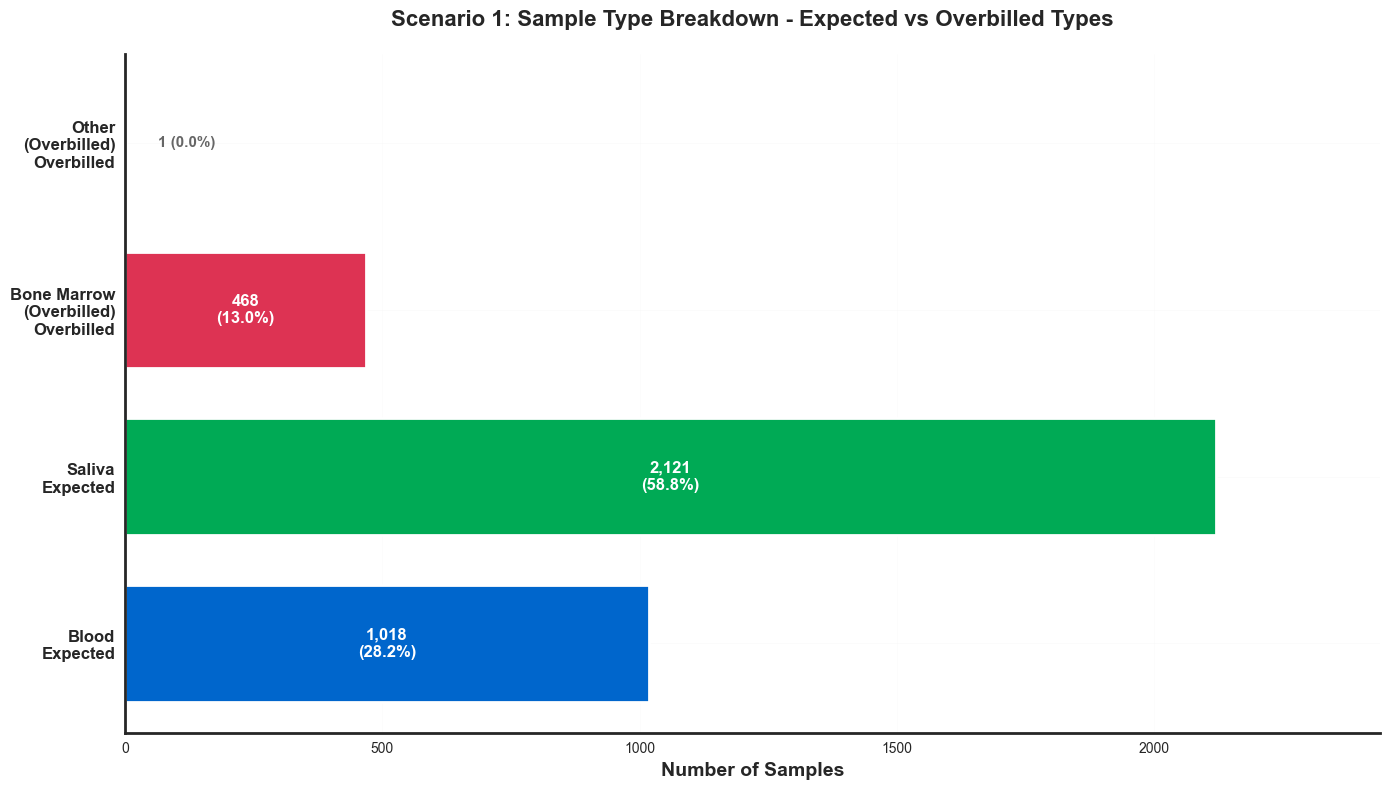

In [43]:
# SCENARIO 1 - VISUAL 3: Sample Type Breakdown

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    sample_counts = billable_live["SAMPLE_TYPE"].value_counts()
    
    blood = sample_counts.get("blood", 0)
    saliva = sample_counts.get("saliva", 0)
    bm = sample_counts.get("bone marrow", 0)
    other_samples = len(billable_live) - blood - saliva - bm
    
    # Prepare data
    labels = ["Blood", "Saliva", "Bone Marrow\n(Overbilled)", "Other\n(Overbilled)"]
    counts = [blood, saliva, bm, other_samples]
    colors_chart = [COLORS["primary"], COLORS["success"], COLORS["danger"], COLORS["neutral"]]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Horizontal bar chart
    bars = ax.barh(range(len(labels)), counts, color=colors_chart, edgecolor='white', linewidth=2, height=0.7)
    
    # Y-axis labels
    y_labels = []
    for i, (label, count, is_expected) in enumerate(zip(labels, counts, [True, True, False, False])):
        status = "Expected" if is_expected else "Overbilled"
        pct = (count / sum(counts)) * 100
        y_labels.append(f"{label}\n{status}")
    
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(y_labels, fontsize=12, weight='bold')
    
    # Value labels - positioned clearly
    max_count = max(counts)
    for i, (v, color) in enumerate(zip(counts, colors_chart)):
        pct = (v / sum(counts)) * 100
        # Label inside bar if bar is wide enough, outside otherwise
        if v > max_count * 0.15:
            ax.text(v/2, i, f"{v:,}\n({pct:.1f}%)", 
                   ha="center", va="center", fontsize=12, weight='bold', color='white')
        else:
            ax.text(v + max_count * 0.03, i, f"{v:,} ({pct:.1f}%)", 
                   va="center", fontsize=11, weight='bold', color=color)
    
    ax.set_xlabel("Number of Samples", fontsize=14, weight="bold")
    ax.set_title("Scenario 1: Sample Type Breakdown - Expected vs Overbilled Types",
                 fontsize=16, weight="bold", pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.grid(axis='x', alpha=0.2)
    ax.set_xlim(0, max_count * 1.15)
    
    plt.tight_layout()
    plt.show()

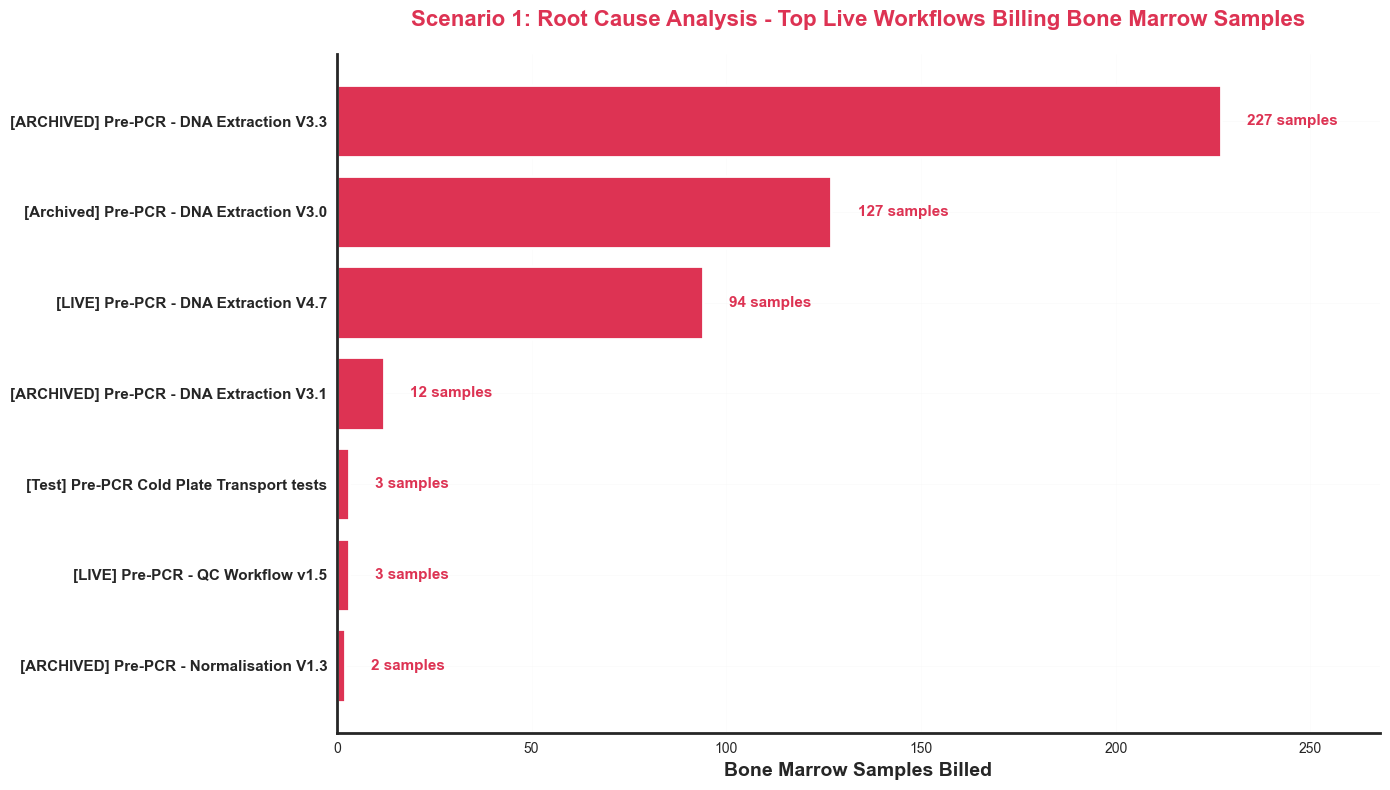

In [44]:
# SCENARIO 1 - VISUAL 4: Root Cause Analysis - Workflows Processing Bone Marrow

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    bm_data = billable_live[billable_live["SAMPLE_TYPE"] == "bone marrow"]
    
    if len(bm_data) > 0:
        top_workflows = bm_data["WORKFLOW_NAME"].value_counts().head(8).sort_values()
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        bars = ax.barh(range(len(top_workflows)), top_workflows.values, 
                      color=COLORS["danger"], edgecolor='white', linewidth=2)
        
        ax.set_yticks(range(len(top_workflows)))
        workflow_labels = []
        for name in top_workflows.index:
            if len(name) > 65:
                workflow_labels.append(name[:62] + "...")
            else:
                workflow_labels.append(name)
        ax.set_yticklabels(workflow_labels, fontsize=11, weight='bold')
        
        # Add value labels - positioned clearly
        max_val = max(top_workflows.values)
        for i, v in enumerate(top_workflows.values):
            label_x = v + max_val * 0.03
            ax.text(label_x, i, f"{v:,} samples", 
                   va="center", fontsize=11, weight='bold', color=COLORS["danger"])
        
        ax.set_xlabel("Bone Marrow Samples Billed", fontsize=14, weight="bold")
        ax.set_title("Scenario 1: Root Cause Analysis - Top Live Workflows Billing Bone Marrow Samples",
                    fontsize=16, weight="bold", pad=20, color=COLORS["danger"])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.grid(axis='x', alpha=0.2)
        ax.set_xlim(0, max_val * 1.18)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No bone marrow samples found in billable data.")

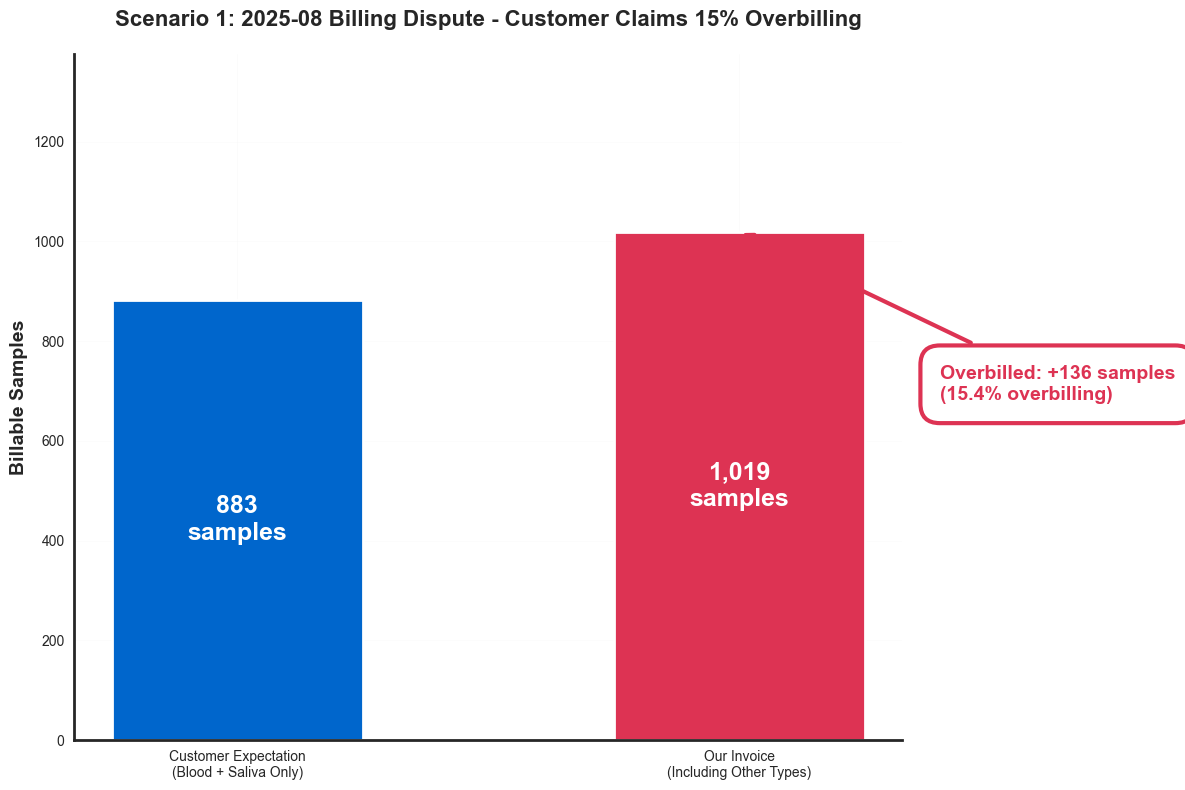

In [45]:
# SCENARIO 1 - VISUAL 1: The Billing Dispute (Executive Summary)

if 'billable_live' not in locals() or billable_live.empty:
    print("Run the Scenario 1 metrics cell first.")
else:
    monthly_plot = monthly.reset_index().copy()
    monthly_plot["YEAR_MONTH_STR"] = monthly_plot["YEAR_MONTH"].astype(str)
    latest_month = monthly_plot["YEAR_MONTH"].max()
    latest_row = monthly[monthly.index == latest_month].iloc[0]
    
    expected_val = latest_row["BLOOD_SALIVA"]
    actual_val = latest_row["TOTAL_SAMPLES"]
    other_val = latest_row["OTHER_TYPES"]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bars = ax.bar(
        ["Customer Expectation\n(Blood + Saliva Only)", "Our Invoice\n(Including Other Types)"],
        [expected_val, actual_val],
        color=[COLORS["primary"], COLORS["danger"]],
        width=0.5,
        edgecolor="white",
        linewidth=2
    )
    
    # Value labels on bars - clear white text
    ax.text(0, expected_val/2, f"{int(expected_val):,}\nsamples",
            ha="center", va="center", fontsize=18, weight="bold", color="white")
    ax.text(1, actual_val/2, f"{int(actual_val):,}\nsamples",
            ha="center", va="center", fontsize=18, weight="bold", color="white")
    
    # Overbilling annotation - positioned clearly
    ax.annotate(f"Overbilled: +{int(other_val):,} samples\n({latest_row['OVERBILLING_PCT']:.1f}% overbilling)",
                xy=(1, actual_val), xytext=(1.4, actual_val * 0.7),
                ha="left", va="center", fontsize=14, weight="bold", color=COLORS["danger"],
                bbox=dict(boxstyle="round,pad=1", facecolor="white", edgecolor=COLORS["danger"], linewidth=3),
                arrowprops=dict(arrowstyle="->", color=COLORS["danger"], lw=3))
    
    ax.set_ylabel("Billable Samples", fontsize=14, weight="bold")
    ax.set_title(f"Scenario 1: {latest_month} Billing Dispute - Customer Claims 15% Overbilling",
                 fontsize=16, weight="bold", pad=20)
    ax.set_ylim(0, actual_val * 1.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.grid(axis='y', alpha=0.2)
    
    plt.tight_layout()
    plt.show()


## Scenario 2 – Customer Health: Narrative

- **What we measure**  
  - Focus on **live, finished, billable** samples (same definition as Scenario 1).  
  - Monthly view of billable sample volume and number of unique production runs.  
  - Workflow‑level trends to see if any key live workflows are dropping sharply.

- **Overall monthly usage trend (live billable)**  
  - 2025‑05: 627 billable samples (13 live runs).  
  - 2025‑06: 707 billable samples (11 runs), **+12.8%** vs May.  
  - 2025‑07: 1,255 billable samples (22 runs), **+77.5%** vs June.  
  - 2025‑08: 1,019 billable samples (18 runs), **−18.8%** vs July.

- **Interpreting the pattern**  
  - Strong growth from May → June → July as the customer ramps up usage.  
  - In August there is a **single significant drop (~19%)** relative to July, but volume is still **higher than in May/June**.  
  - On a 3‑month moving average basis, the last 3 months (Jun–Aug) are still **~15% higher** than the previous 3‑month window, so overall usage remains on an upward trajectory.

- **Workflow‑level health**  
  - We compare the last two months’ volume per live workflow.  
  - Workflows with >20% decline are flagged.  
  - In this data, the workflows with large declines between July and August are marked as **`[ARCHIVED]`**, suggesting that they are being intentionally phased out rather than indicating a healthy live workflow falling away.

- **Risk assessment**  
  - **Short‑term risk:** August’s ~19% drop is a warning sign and worth monitoring, especially if the customer has seasonality or known external drivers.  
  - **Medium‑term risk:** Because the 3‑month average is still above the previous period and declines are concentrated in archived workflows, the customer does **not yet** look like they are systematically churning away from the platform.  
  - **Action:**  
    - Monitor billable volume by month and by key live workflows for the next 1–2 months.  
    - If further consecutive declines occur, treat the account as **at‑risk** and engage proactively (e.g. review operational issues, success rates, backlog).



/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_34281/1289510904.py:69: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_34281/1289510904.py:69: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


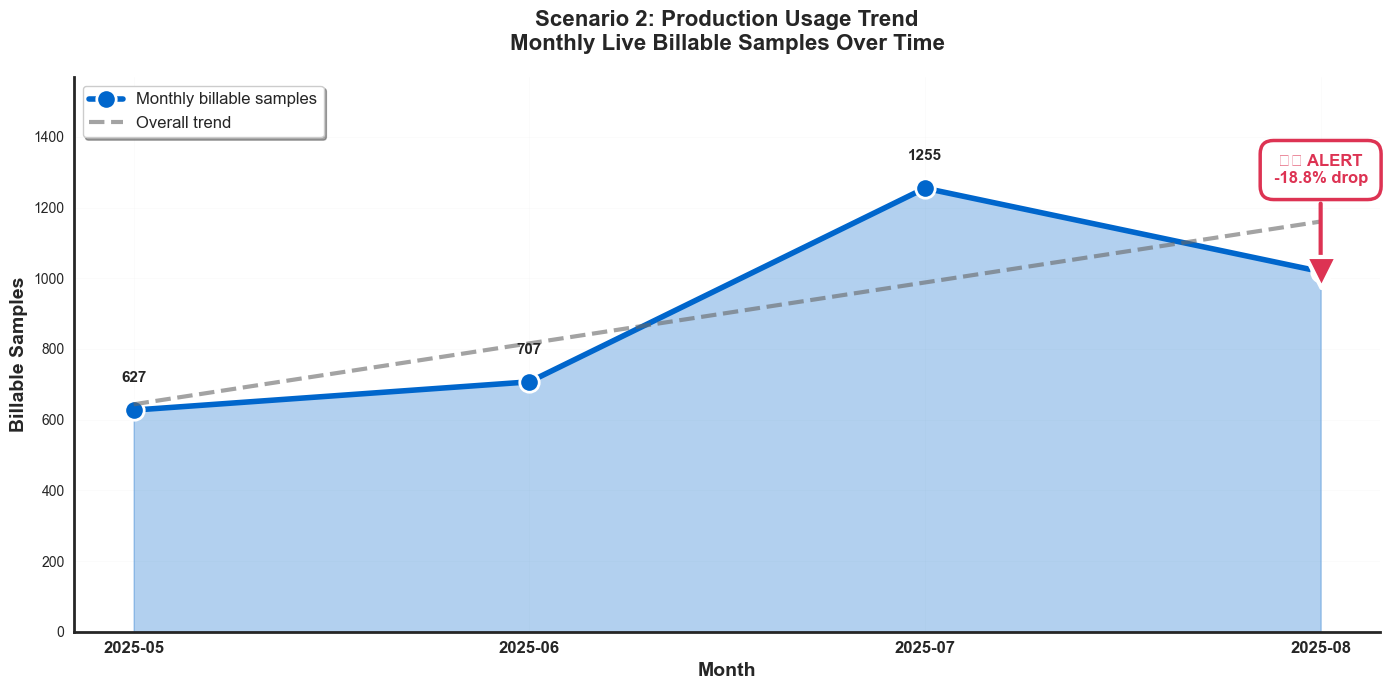

/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/megpatakota/Library/Caches/pypoetry/virtualenvs/automata-qwLfLazj-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  fig.canva

📊 TREND ANALYSIS: From 2025-05 to 2025-08: +62.5% overall growth (627 → 1019 samples)


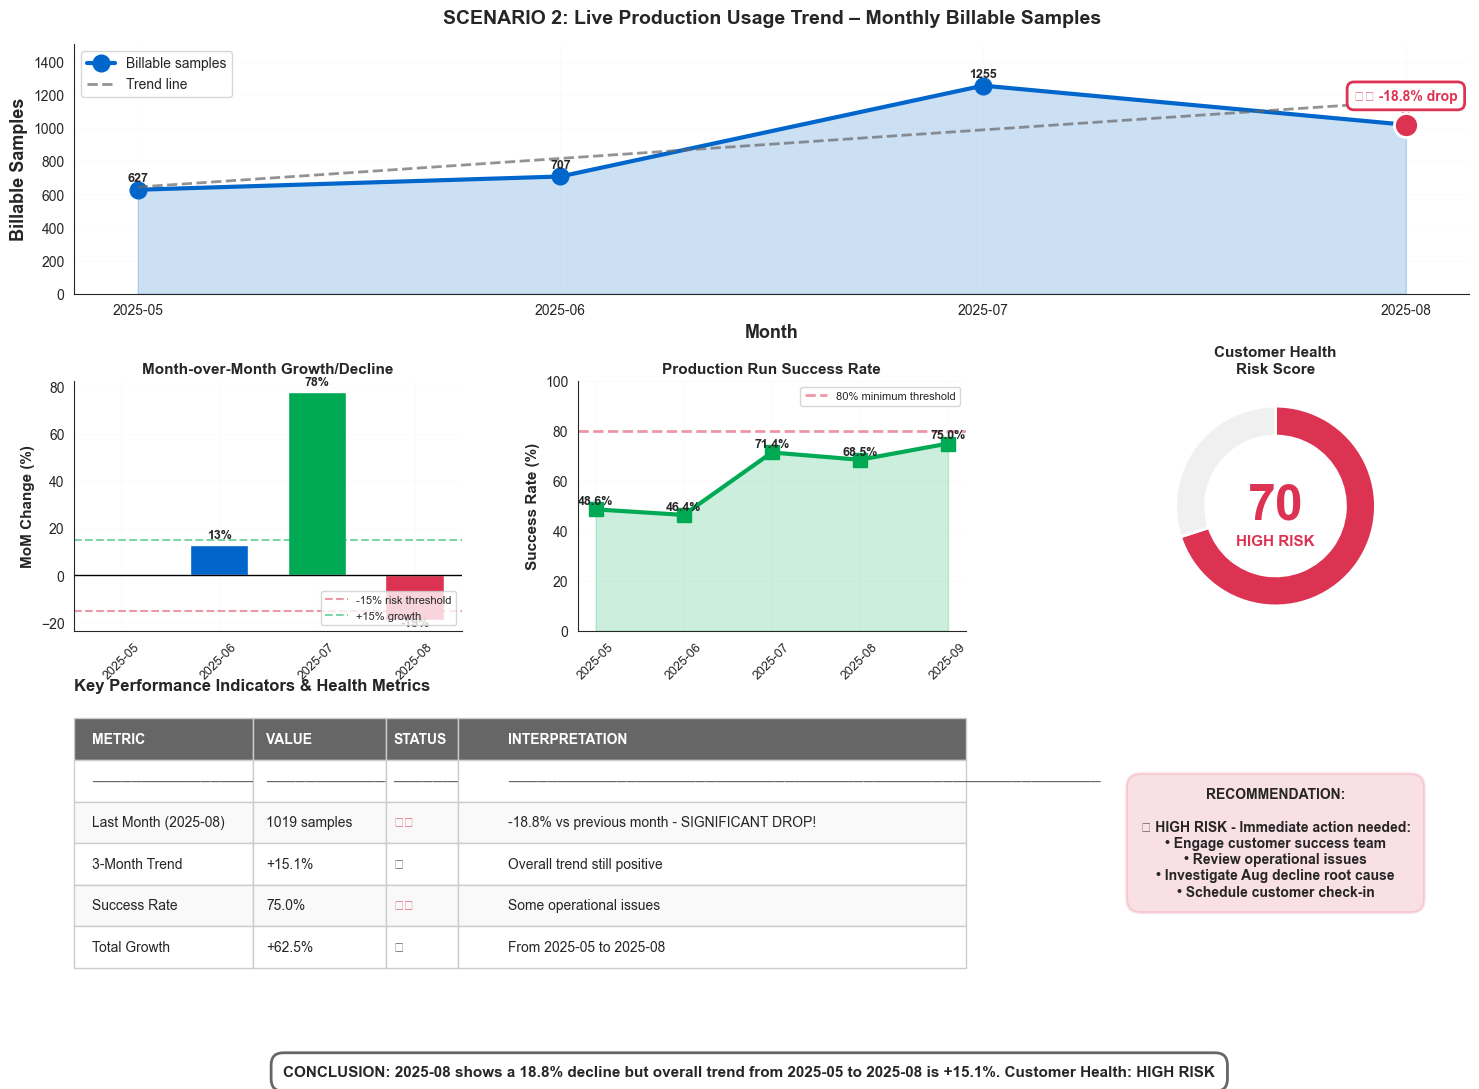

In [46]:
# SCENARIO 2 - VISUAL 1: Customer Usage Trend Over Time

if 'billable_live' not in locals() or billable_live.empty:
    print("⚠️ Run Scenario 1 cells first.")
else:
    billable_live_s2 = billable_live.copy()
    billable_live_s2["YEAR_MONTH"] = billable_live_s2["TIMESTAMP"].dt.to_period("M")
    
    usage_monthly = (
        billable_live_s2.groupby("YEAR_MONTH").agg(
            BILLABLE_SAMPLES=("RUN_ID", "count"),
            UNIQUE_RUNS=("RUN_ID", "nunique"),
        ).sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["BILLABLE_SAMPLES"].pct_change() * 100
    um_plot = usage_monthly.reset_index().copy()
    um_plot["YEAR_MONTH_STR"] = um_plot["YEAR_MONTH"].astype(str)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Fill area under curve
    ax.fill_between(range(len(um_plot)), 0, um_plot["BILLABLE_SAMPLES"],
                     alpha=0.3, color=COLORS["primary"])
    
    # Main line
    ax.plot(range(len(um_plot)), um_plot["BILLABLE_SAMPLES"],
            marker="o", markersize=14, linewidth=4, color=COLORS["primary"], 
            label="Monthly billable samples", markeredgecolor='white', markeredgewidth=2)
    
    # Add trend line
    z = np.polyfit(range(len(um_plot)), um_plot["BILLABLE_SAMPLES"], 1)
    p = np.poly1d(z)
    ax.plot(range(len(um_plot)), p(range(len(um_plot))),
            linestyle="--", linewidth=3, color=COLORS["neutral"], alpha=0.6, label="Overall trend")
    
    # Highlight concerning drops and add annotations
    for i, (idx, row) in enumerate(um_plot.iterrows()):
        val = row["BILLABLE_SAMPLES"]
        mom = row["MOM_CHANGE_PCT"]
        
        if mom < -15:
            # Big red marker for significant drop
            ax.scatter(i, val, s=500, color=COLORS["danger"], zorder=5, 
                      edgecolor="white", linewidth=3, marker='v')
            ax.annotate(f"⚠️ ALERT\n{mom:.1f}% drop",
                        xy=(i, val), xytext=(i, val + 250),
                        ha="center", fontsize=12, weight="bold", color=COLORS["danger"],
                        bbox=dict(boxstyle="round,pad=0.8", facecolor="white", 
                                 edgecolor=COLORS["danger"], linewidth=2.5),
                        arrowprops=dict(arrowstyle="->", color=COLORS["danger"], lw=3))
        else:
            # Show value for normal months
            ax.text(i, val + 80, f"{int(val)}", ha="center", fontsize=11, weight="bold")
    
    ax.set_xticks(range(len(um_plot)))
    ax.set_xticklabels(um_plot["YEAR_MONTH_STR"], fontsize=12, weight="bold")
    ax.set_ylabel("Billable Samples", fontsize=14, weight="bold")
    ax.set_xlabel("Month", fontsize=14, weight="bold")
    ax.set_title("Scenario 2: Production Usage Trend\nMonthly Live Billable Samples Over Time",
                 fontsize=16, weight="bold", pad=20)
    ax.legend(loc="upper left", frameon=True, fontsize=12, shadow=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.set_ylim(0, um_plot["BILLABLE_SAMPLES"].max() * 1.25)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall growth
    first_month = um_plot.iloc[0]
    last_month = um_plot.iloc[-1]
    total_growth = ((last_month["BILLABLE_SAMPLES"] / first_month["BILLABLE_SAMPLES"]) - 1) * 100
    print(f"📊 TREND ANALYSIS: From {first_month['YEAR_MONTH_STR']} to {last_month['YEAR_MONTH_STR']}: " +
          f"{total_growth:+.1f}% overall growth ({int(first_month['BILLABLE_SAMPLES'])} → {int(last_month['BILLABLE_SAMPLES'])} samples)")
    
    # Success rate data
    runs_live_s2 = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
    runs_live_s2["YEAR_MONTH"] = runs_live_s2["START_TIME"].dt.to_period("M")
    success_monthly = runs_live_s2.groupby("YEAR_MONTH").agg(
        TOTAL_RUNS=("ID", "count"),
        FINISHED=("OUTCOME", lambda s: (s == "finished").sum()),
        FAILED=("OUTCOME", lambda s: (s == "failed").sum()),
        CANCELED=("OUTCOME", lambda s: (s == "canceled").sum())
    )
    success_monthly["SUCCESS_RATE"] = (success_monthly["FINISHED"] / success_monthly["TOTAL_RUNS"] * 100)
    sr_plot = success_monthly.reset_index().copy()
    sr_plot["YEAR_MONTH_STR"] = sr_plot["YEAR_MONTH"].astype(str)
    
    # Create comprehensive dashboard
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # === ROW 1: USAGE TREND ===
    
    # 1. Main usage chart with trend line
    ax1 = fig.add_subplot(gs[0, :])
    ax1.fill_between(range(len(um_plot)), 0, um_plot["BILLABLE_SAMPLES"],
                     alpha=0.2, color=COLORS["primary"])
    ax1.plot(range(len(um_plot)), um_plot["BILLABLE_SAMPLES"],
            marker="o", markersize=12, linewidth=3, color=COLORS["primary"], label="Billable samples")
    
    # Add trend line
    z = np.polyfit(range(len(um_plot)), um_plot["BILLABLE_SAMPLES"], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(um_plot)), p(range(len(um_plot))),
            linestyle="--", linewidth=2, color=COLORS["neutral"], alpha=0.7, label="Trend line")
    
    # Highlight concerning drops
    for i, (idx, row) in enumerate(um_plot.iterrows()):
        val = row["BILLABLE_SAMPLES"]
        mom = row["MOM_CHANGE_PCT"]
        if mom < -15:
            ax1.scatter(i, val, s=300, color=COLORS["danger"], zorder=5, edgecolor="white", linewidth=2)
            ax1.annotate(f"⚠️ {mom:.1f}% drop",
                        xy=(i, val), xytext=(i, val + 150),
                        ha="center", fontsize=10, weight="bold", color=COLORS["danger"],
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor=COLORS["danger"], linewidth=2),
                        arrowprops=dict(arrowstyle="->", color=COLORS["danger"], lw=2))
        else:
            ax1.text(i, val + 50, f"{int(val)}", ha="center", fontsize=9, weight="bold")
    
    ax1.set_xticks(range(len(um_plot)))
    ax1.set_xticklabels(um_plot["YEAR_MONTH_STR"], rotation=0)
    ax1.set_ylabel("Billable Samples", fontsize=13, weight="bold")
    ax1.set_xlabel("Month", fontsize=13, weight="bold")
    ax1.set_title("SCENARIO 2: Live Production Usage Trend – Monthly Billable Samples",
                 fontsize=14, weight="bold", pad=15)
    ax1.legend(loc="upper left", frameon=True, fontsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(0, um_plot["BILLABLE_SAMPLES"].max() * 1.2)
    
    # === ROW 2: ANALYSIS ===
    
    # 2. MoM Change (waterfall-style)
    ax2 = fig.add_subplot(gs[1, 0])
    colors_bar = [COLORS["danger"] if x < -15 else COLORS["success"] if x > 15 else COLORS["primary"] 
                  for x in um_plot["MOM_CHANGE_PCT"].fillna(0)]
    bars = ax2.bar(range(len(um_plot)), um_plot["MOM_CHANGE_PCT"].fillna(0), color=colors_bar, width=0.6)
    ax2.axhline(y=0, color="black", linewidth=1)
    ax2.axhline(y=-15, color=COLORS["danger"], linestyle="--", linewidth=1.5, alpha=0.5, label="-15% risk threshold")
    ax2.axhline(y=15, color=COLORS["success"], linestyle="--", linewidth=1.5, alpha=0.5, label="+15% growth")
    
    for i, v in enumerate(um_plot["MOM_CHANGE_PCT"].fillna(0)):
        if abs(v) > 5:
            ax2.text(i, v + (3 if v > 0 else -3), f"{v:.0f}%", ha="center", fontsize=9, weight="bold")
    
    ax2.set_xticks(range(len(um_plot)))
    ax2.set_xticklabels(um_plot["YEAR_MONTH_STR"], rotation=45, fontsize=9)
    ax2.set_ylabel("MoM Change (%)", fontsize=11, weight="bold")
    ax2.set_title("Month-over-Month Growth/Decline", fontsize=11, weight="bold")
    ax2.legend(fontsize=8, loc="lower right")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # 3. Success Rate tracking
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(range(len(sr_plot)), sr_plot["SUCCESS_RATE"],
            marker="s", markersize=10, linewidth=3, color=COLORS["success"])
    ax3.fill_between(range(len(sr_plot)), 0, sr_plot["SUCCESS_RATE"],
                     alpha=0.2, color=COLORS["success"])
    ax3.axhline(y=80, color=COLORS["danger"], linestyle="--", linewidth=2, alpha=0.5, label="80% minimum threshold")
    
    for i, v in enumerate(sr_plot["SUCCESS_RATE"]):
        ax3.text(i, v + 2, f"{v:.1f}%", ha="center", fontsize=9, weight="bold")
    
    ax3.set_xticks(range(len(sr_plot)))
    ax3.set_xticklabels(sr_plot["YEAR_MONTH_STR"], rotation=45, fontsize=9)
    ax3.set_ylabel("Success Rate (%)", fontsize=11, weight="bold")
    ax3.set_title("Production Run Success Rate", fontsize=11, weight="bold")
    ax3.set_ylim(0, 100)
    ax3.legend(fontsize=8)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # 4. Risk Gauge
    ax4 = fig.add_subplot(gs[1, 2])
    # Calculate risk score based on: recent drop + success rate
    last_mom = um_plot["MOM_CHANGE_PCT"].iloc[-1]
    last_success = sr_plot["SUCCESS_RATE"].iloc[-1]
    
    risk_score = 0
    if last_mom < -15:
        risk_score += 40
    elif last_mom < 0:
        risk_score += 20
    if last_success < 80:
        risk_score += 30
    elif last_success < 90:
        risk_score += 15
        
    # 3-month trend
    last_3_avg = um_plot["BILLABLE_SAMPLES"].tail(3).mean()
    first_3_avg = um_plot["BILLABLE_SAMPLES"].head(3).mean()
    trend_pct = ((last_3_avg - first_3_avg) / first_3_avg * 100) if first_3_avg > 0 else 0
    
    if trend_pct < -10:
        risk_score += 30
        
    risk_color = COLORS["danger"] if risk_score > 50 else COLORS["warning"] if risk_score > 25 else COLORS["success"]
    risk_status = "HIGH RISK" if risk_score > 50 else "MODERATE RISK" if risk_score > 25 else "HEALTHY"
    
    ax4.pie([risk_score, 100-risk_score], colors=[risk_color, "#f0f0f0"],
           startangle=90, counterclock=False, wedgeprops=dict(width=0.3, edgecolor="white", linewidth=2))
    ax4.text(0, 0, f"{risk_score:.0f}", ha="center", va="center", fontsize=36, weight="bold", color=risk_color)
    ax4.text(0, -0.35, risk_status, ha="center", va="center", fontsize=11, weight="bold", color=risk_color)
    ax4.set_title("Customer Health\nRisk Score", fontsize=11, weight="bold")
    
    # === ROW 3: INSIGHTS ===
    
    # 5. Detailed metrics table
    ax5 = fig.add_subplot(gs[2, :2])
    ax5.axis("off")
    
    # Build insights
    insights = [
        ["METRIC", "VALUE", "STATUS", "INTERPRETATION"],
        ["─"*40, "─"*20, "─"*15, "─"*60],
        [f"Last Month ({um_plot['YEAR_MONTH_STR'].iloc[-1]})", f"{int(um_plot['BILLABLE_SAMPLES'].iloc[-1])} samples", 
         "⚠️" if last_mom < -15 else "✓",
         f"{last_mom:.1f}% vs previous month" + (" - SIGNIFICANT DROP!" if last_mom < -15 else "")],
        ["3-Month Trend", f"{trend_pct:+.1f}%", 
         "⚠️" if trend_pct < -10 else "✓",
         "Overall trend still positive" if trend_pct > 0 else "Declining trend - monitor closely"],
        ["Success Rate", f"{last_success:.1f}%", 
         "⚠️" if last_success < 80 else "✓",
         "Production runs performing well" if last_success >= 90 else "Some operational issues"],
        ["Total Growth", f"{((um_plot['BILLABLE_SAMPLES'].iloc[-1] / um_plot['BILLABLE_SAMPLES'].iloc[0]) - 1) * 100:+.1f}%",
         "✓", f"From {um_plot['YEAR_MONTH_STR'].iloc[0]} to {um_plot['YEAR_MONTH_STR'].iloc[-1]}"]
    ]
    
    table = ax5.table(cellText=insights, cellLoc="left", loc="center",
                     colWidths=[0.2, 0.15, 0.08, 0.57],
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    for i in range(len(insights)):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor(COLORS["neutral"])
                cell.set_text_props(weight="bold", color="white")
            elif i == 1:  # Separator
                cell.set_facecolor("white")
                cell.set_text_props(color=COLORS["neutral"])
            else:
                cell.set_facecolor("#f9f9f9" if i % 2 == 0 else "white")
                if j == 2 and "⚠️" in str(insights[i][j]):
                    cell.set_text_props(color=COLORS["danger"], weight="bold")
            cell.set_edgecolor(COLORS["light"])
    
    ax5.set_title("Key Performance Indicators & Health Metrics", fontsize=12, weight="bold", pad=20, loc="left")
    
    # 6. Recommendation box
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis("off")
    
    recommendation = "RECOMMENDATION:\n\n"
    if risk_score > 50:
        recommendation += "🔴 HIGH RISK - Immediate action needed:\n• Engage customer success team\n• Review operational issues\n• Investigate Aug decline root cause\n• Schedule customer check-in"
        rec_color = COLORS["danger"]
    elif risk_score > 25:
        recommendation += "🟡 MONITOR CLOSELY:\n• Track next month closely\n• Proactive outreach\n• Review workflow changes\n• Monitor success rates"
        rec_color = COLORS["warning"]
    else:
        recommendation += "✅ HEALTHY STATUS:\n• Customer usage growing\n• High success rates\n• Continue standard monitoring\n• Maintain service quality"
        rec_color = COLORS["success"]
    
    ax6.text(0.5, 0.5, recommendation, ha="center", va="center", fontsize=10, weight="bold",
            bbox=dict(boxstyle="round,pad=1", facecolor=rec_color, alpha=0.15, edgecolor=rec_color, linewidth=2),
            wrap=True)
    
    # Overall conclusion
    fig.text(0.5, 0.02,
            f"CONCLUSION: {um_plot['YEAR_MONTH_STR'].iloc[-1]} shows a {abs(last_mom):.1f}% decline but overall trend from " +
            f"{um_plot['YEAR_MONTH_STR'].iloc[0]} to {um_plot['YEAR_MONTH_STR'].iloc[-1]} is {'+' if trend_pct > 0 else ''}{trend_pct:.1f}%. " +
            f"Customer Health: {risk_status}",
            ha="center", fontsize=11, weight="bold",
            bbox=dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor=COLORS["neutral"], linewidth=2))
    
    plt.show()


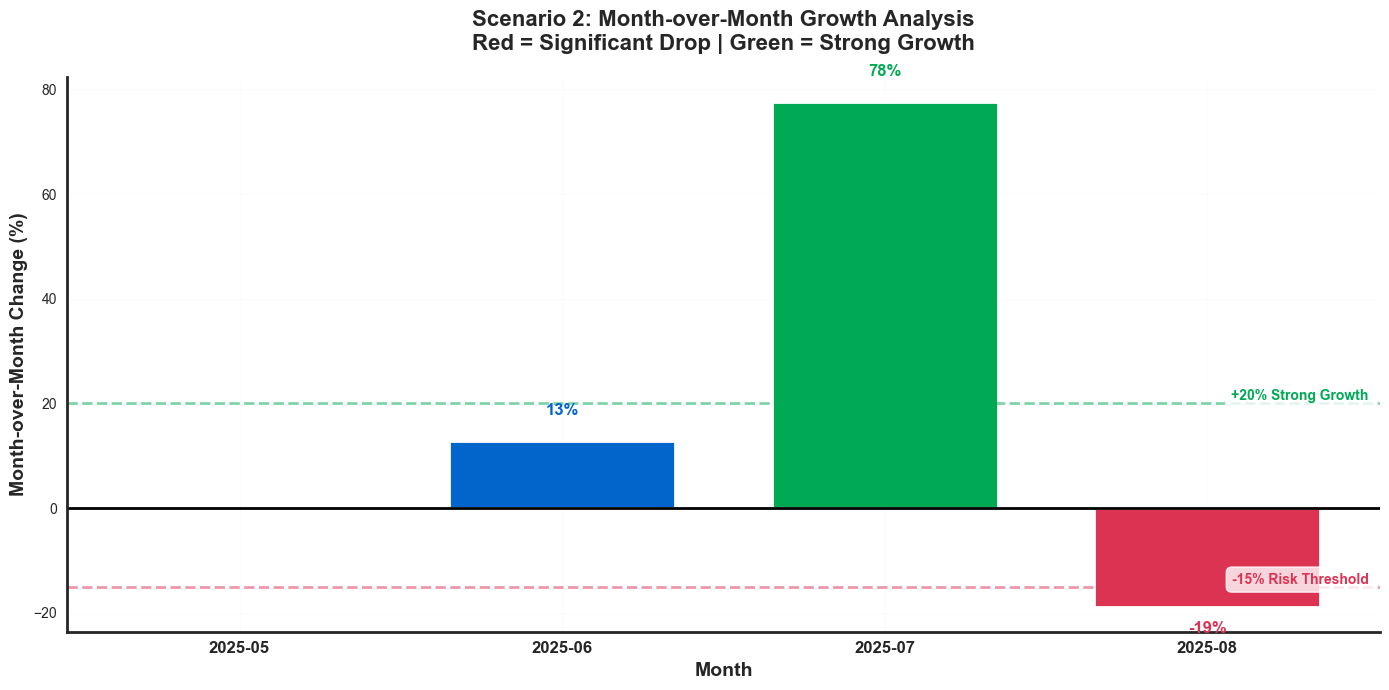

📊 VOLATILITY ANALYSIS: 1 month(s) with >15% drop. 1 month(s) with >20% growth.


In [47]:
# SCENARIO 2 - VISUAL 2: Month-over-Month Growth Rate

if 'billable_live' not in locals() or billable_live.empty:
    print("⚠️ Run previous cells first.")
else:
    billable_live_s2 = billable_live.copy()
    billable_live_s2["YEAR_MONTH"] = billable_live_s2["TIMESTAMP"].dt.to_period("M")
    
    usage_monthly = (
        billable_live_s2.groupby("YEAR_MONTH").agg(
            BILLABLE_SAMPLES=("RUN_ID", "count"),
        ).sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["BILLABLE_SAMPLES"].pct_change() * 100
    um_plot = usage_monthly.reset_index().copy()
    um_plot["YEAR_MONTH_STR"] = um_plot["YEAR_MONTH"].astype(str)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Color bars based on thresholds
    colors_bar = []
    for v in um_plot["MOM_CHANGE_PCT"].fillna(0):
        if v < -15:
            colors_bar.append(COLORS["danger"])
        elif v > 20:
            colors_bar.append(COLORS["success"])
        elif v > 0:
            colors_bar.append(COLORS["primary"])
        else:
            colors_bar.append(COLORS["warning"])
    
    bars = ax.bar(range(len(um_plot)), um_plot["MOM_CHANGE_PCT"].fillna(0), 
                  color=colors_bar, width=0.7, edgecolor='white', linewidth=2)
    
    # Add reference lines
    ax.axhline(y=0, color="black", linewidth=2)
    ax.axhline(y=-15, color=COLORS["danger"], linestyle="--", linewidth=2, alpha=0.5)
    ax.axhline(y=20, color=COLORS["success"], linestyle="--", linewidth=2, alpha=0.5)
    
    # Add value labels
    for i, v in enumerate(um_plot["MOM_CHANGE_PCT"].fillna(0)):
        if abs(v) > 2:
            y_pos = v + (5 if v > 0 else -5)
            ax.text(i, y_pos, f"{v:.0f}%", ha="center", fontsize=12, weight="bold",
                   color=colors_bar[i])
    
    # Add threshold labels
    ax.text(len(um_plot) - 0.5, -15, "-15% Risk Threshold", ha="right", va="bottom",
           fontsize=10, color=COLORS["danger"], weight="bold",
           bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8))
    ax.text(len(um_plot) - 0.5, 20, "+20% Strong Growth", ha="right", va="bottom",
           fontsize=10, color=COLORS["success"], weight="bold",
           bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8))
    
    ax.set_xticks(range(len(um_plot)))
    ax.set_xticklabels(um_plot["YEAR_MONTH_STR"], fontsize=12, weight="bold")
    ax.set_ylabel("Month-over-Month Change (%)", fontsize=14, weight="bold")
    ax.set_xlabel("Month", fontsize=14, weight="bold")
    ax.set_title("Scenario 2: Month-over-Month Growth Analysis\nRed = Significant Drop | Green = Strong Growth",
                 fontsize=16, weight="bold", pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    drops = um_plot[um_plot["MOM_CHANGE_PCT"] < -15]
    growth = um_plot[um_plot["MOM_CHANGE_PCT"] > 20]
    print(f"📊 VOLATILITY ANALYSIS: {len(drops)} month(s) with >15% drop. {len(growth)} month(s) with >20% growth.")


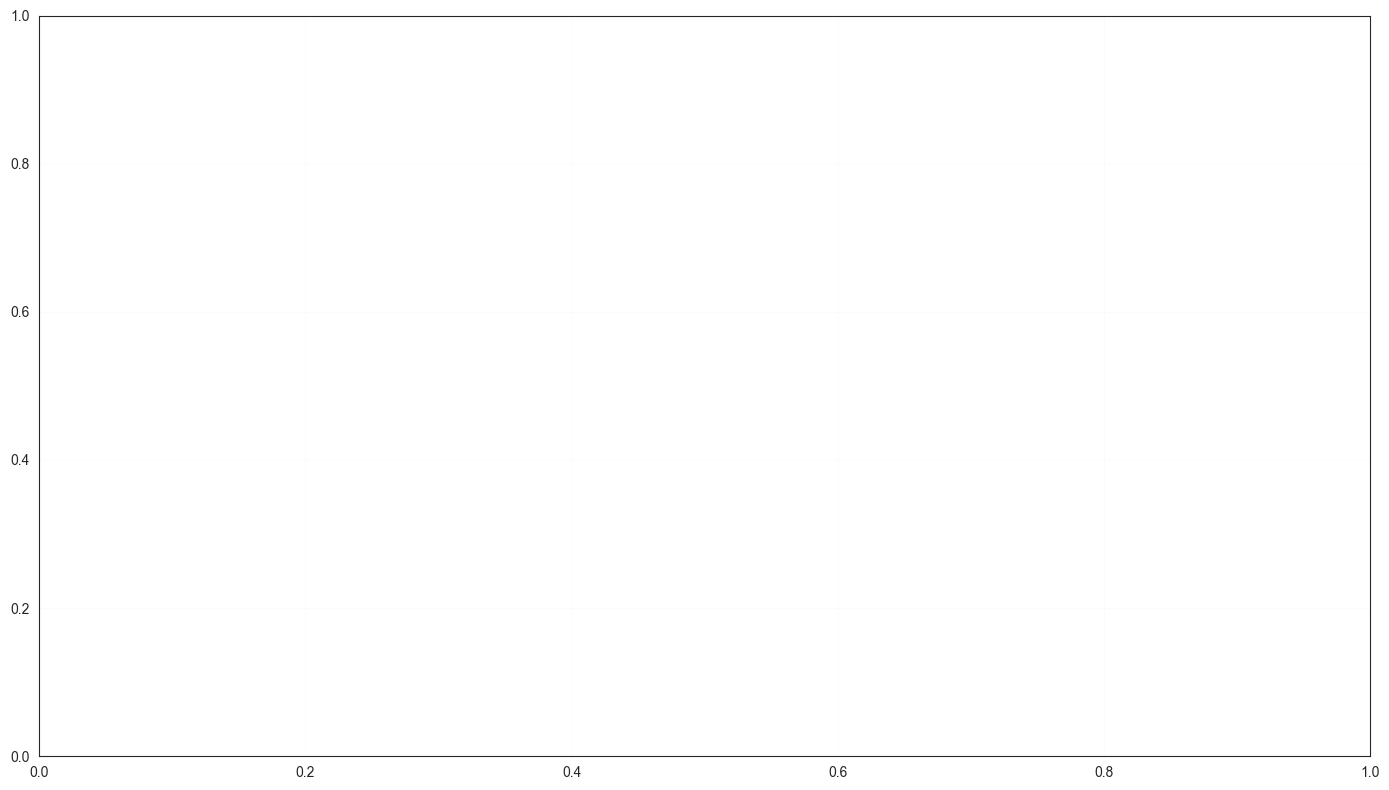

📊 QUALITY METRIC: Average success rate = 62.0%. 🔴 Operational issues detected


In [48]:
# SCENARIO 2 - VISUAL 3: Production Run Success Rate

if 'df_runs' not in locals() or df_runs.empty:
    print("Run previous cells first.")
else:
    runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
    runs_live["YEAR_MONTH"] = runs_live["START_TIME"].dt.to_period("M")
    
    success_monthly = runs_live.groupby("YEAR_MONTH").agg(
        TOTAL_RUNS=("ID", "count"),
        FINISHED=("OUTCOME", lambda s: (s == "finished").sum()),
        FAILED=("OUTCOME", lambda s: (s == "failed").sum()),
        CANCELED=("OUTCOME", lambda s: (s == "canceled").sum())
    )
    success_monthly["SUCCESS_RATE"] = (success_monthly["FINISHED"] / success_monthly["TOTAL_RUNS"] * 100)
    sr_plot = success_monthly.reset_index().copy()
    sr_plot["YEAR_MONTH_STR"] = sr_plot["YEAR_MONTH"].astype(str)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # LEFT: Success rate line chart
    ax1.plot(range(len(sr_plot)), sr_plot["SUCCESS_RATE"],
            marker="s", markersize=12, linewidth=4, color=COLORS["success"],
            label="Success Rate", markeredgecolor='white', markeredgewidth=2)
    ax1.fill_between(range(len(sr_plot)), 0, sr_plot["SUCCESS_RATE"],
                     alpha=0.3, color=COLORS["success"])
    
    # Add threshold lines
    ax1.axhline(y=90, color=COLORS["success"], linestyle="--", linewidth=2, alpha=0.5, label="90% Target")
    ax1.axhline(y=80, color=COLORS["warning"], linestyle="--", linewidth=2, alpha=0.5, label="80% Warning")
    
    # Add value labels
    for i, v in enumerate(sr_plot["SUCCESS_RATE"]):
        color = COLORS["success"] if v >= 90 else COLORS["warning"] if v >= 80 else COLORS["danger"]
        ax1.text(i, v + 2, f"{v:.1f}%", ha="center", fontsize=11, weight="bold", color=color)
    
    ax1.set_xticks(range(len(sr_plot)))
    ax1.set_xticklabels(sr_plot["YEAR_MONTH_STR"], fontsize=11, weight="bold")
    ax1.set_ylabel("Success Rate (%)", fontsize=13, weight="bold")
    ax1.set_xlabel("Month", fontsize=13, weight="bold")
    ax1.set_title("Production Run Success Rate Trend", fontsize=14, weight="bold", pad=15)
    ax1.set_ylim(0, 100)
    ax1.legend(fontsize=10, loc="lower right")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.grid(axis='y', alpha=0.3)
    
    # RIGHT: Stacked bar for run outcomes
    width = 0.7
    finished_pct = (sr_plot["FINISHED"] / sr_plot["TOTAL_RUNS"] * 100)
    failed_pct = (sr_plot["FAILED"] / sr_plot["TOTAL_RUNS"] * 100)
    canceled_pct = (sr_plot["CANCELED"] / sr_plot["TOTAL_RUNS"] * 100)
    
    ax2.bar(range(len(sr_plot)), finished_pct, width, label="Finished", 
           color=COLORS["success"], edgecolor='white', linewidth=2)
    ax2.bar(range(len(sr_plot)), failed_pct, width, bottom=finished_pct,
           label="Failed", color=COLORS["danger"], edgecolor='white', linewidth=2)
    ax2.bar(range(len(sr_plot)), canceled_pct, width, 
           bottom=finished_pct + failed_pct,
           label="Canceled", color=COLORS["neutral"], edgecolor='white', linewidth=2)
    
    # Add total run count labels
    for i, total in enumerate(sr_plot["TOTAL_RUNS"]):
        ax2.text(i, 102, f"{total} runs", ha="center", fontsize=10, weight="bold")
    
    ax2.set_xticks(range(len(sr_plot)))
    ax2.set_xticklabels(sr_plot["YEAR_MONTH_STR"], fontsize=11, weight="bold")
    ax2.set_ylabel("Run Outcome Distribution (%)", fontsize=13, weight="bold")
    ax2.set_xlabel("Month", fontsize=13, weight="bold")
    ax2.set_title("Run Outcome Breakdown (% of Total)", fontsize=14, weight="bold", pad=15)
    ax2.set_ylim(0, 110)
    ax2.legend(fontsize=10, loc="lower right")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    avg_success = sr_plot["SUCCESS_RATE"].mean()
    print(f"📊 QUALITY METRIC: Average success rate = {avg_success:.1f}%. " +
          f"{'✅ Excellent operational quality' if avg_success >= 90 else '⚠️ Room for improvement' if avg_success >= 80 else '🔴 Operational issues detected'}")


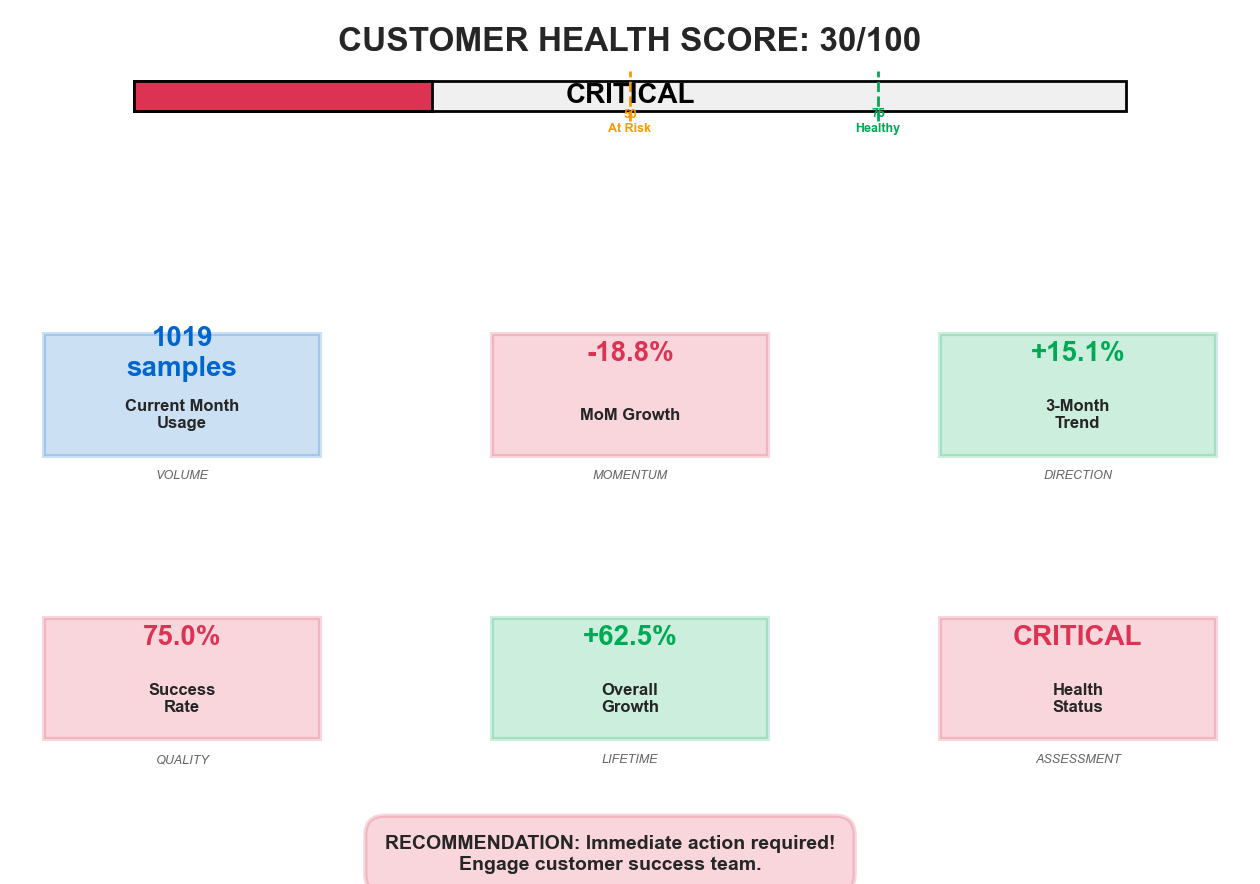

📊 HEALTH SCORE BREAKDOWN: Usage Volume (Last Month) + Growth Momentum + Operational Quality = 30/100


In [49]:
# SCENARIO 2 - VISUAL 4: Customer Health Scorecard

if 'billable_live' not in locals() or billable_live.empty:
    print("⚠️ Run previous cells first.")
else:
    # Calculate metrics
    billable_live_s2 = billable_live.copy()
    billable_live_s2["YEAR_MONTH"] = billable_live_s2["TIMESTAMP"].dt.to_period("M")
    
    usage_monthly = (
        billable_live_s2.groupby("YEAR_MONTH").agg(
            BILLABLE_SAMPLES=("RUN_ID", "count"),
        ).sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["BILLABLE_SAMPLES"].pct_change() * 100
    
    runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
    runs_live["YEAR_MONTH"] = runs_live["START_TIME"].dt.to_period("M")
    success_monthly = runs_live.groupby("YEAR_MONTH").agg(
        TOTAL_RUNS=("ID", "count"),
        FINISHED=("OUTCOME", lambda s: (s == "finished").sum()),
    )
    success_monthly["SUCCESS_RATE"] = (success_monthly["FINISHED"] / success_monthly["TOTAL_RUNS"] * 100)
    
    # Latest metrics
    last_month_usage = usage_monthly.iloc[-1]["BILLABLE_SAMPLES"]
    last_mom = usage_monthly.iloc[-1]["MOM_CHANGE_PCT"]
    last_success = success_monthly.iloc[-1]["SUCCESS_RATE"]
    
    # Trend analysis
    first_month = usage_monthly.iloc[0]["BILLABLE_SAMPLES"]
    total_growth = ((last_month_usage / first_month) - 1) * 100
    
    last_3_avg = usage_monthly["BILLABLE_SAMPLES"].tail(3).mean()
    first_3_avg = usage_monthly["BILLABLE_SAMPLES"].head(3).mean()
    trend_3m = ((last_3_avg - first_3_avg) / first_3_avg * 100)
    
    # Calculate health score
    risk_score = 0
    if last_mom < -15: risk_score += 40
    elif last_mom < 0: risk_score += 20
    if last_success < 80: risk_score += 30
    elif last_success < 90: risk_score += 15
    if trend_3m < -10: risk_score += 30
    
    health_score = 100 - risk_score
    
    if health_score >= 75:
        status = "HEALTHY"
        status_color = COLORS["success"]
        recommendation = "Continue monitoring.\nMaintain service quality."
    elif health_score >= 50:
        status = "AT RISK"
        status_color = COLORS["warning"]
        recommendation = "Monitor closely.\nProactive customer outreach."
    else:
        status = "CRITICAL"
        status_color = COLORS["danger"]
        recommendation = "Immediate action required!\nEngage customer success team."
    
    # Create visual
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    
    # Main health gauge
    ax_gauge = fig.add_subplot(gs[0, :])
    ax_gauge.axis("off")
    
    # Health score as horizontal gauge
    gauge_width = 0.8
    gauge_height = 0.15
    gauge_x = 0.1
    gauge_y = 0.5
    
    # Background (full bar)
    ax_gauge.add_patch(Rectangle((gauge_x, gauge_y), gauge_width, gauge_height,
                                 facecolor="#f0f0f0", edgecolor="black", linewidth=2))
    
    # Filled portion
    fill_width = gauge_width * (health_score / 100)
    ax_gauge.add_patch(Rectangle((gauge_x, gauge_y), fill_width, gauge_height,
                                 facecolor=status_color, edgecolor="black", linewidth=2))
    
    # Score label
    ax_gauge.text(0.5, gauge_y + gauge_height + 0.15, f"CUSTOMER HEALTH SCORE: {health_score}/100",
                 ha="center", fontsize=24, weight="bold")
    ax_gauge.text(0.5, gauge_y + gauge_height/2, f"{status}",
                 ha="center", va="center", fontsize=20, weight="bold", color="white" if health_score > 30 else "black")
    
    # Threshold markers
    ax_gauge.plot([gauge_x + gauge_width * 0.5, gauge_x + gauge_width * 0.5], 
                 [gauge_y - 0.05, gauge_y + gauge_height + 0.05], 
                 color=COLORS["warning"], linewidth=2, linestyle="--")
    ax_gauge.text(gauge_x + gauge_width * 0.5, gauge_y - 0.1, "50\nAt Risk", 
                 ha="center", fontsize=9, weight="bold", color=COLORS["warning"])
    
    ax_gauge.plot([gauge_x + gauge_width * 0.75, gauge_x + gauge_width * 0.75], 
                 [gauge_y - 0.05, gauge_y + gauge_height + 0.05], 
                 color=COLORS["success"], linewidth=2, linestyle="--")
    ax_gauge.text(gauge_x + gauge_width * 0.75, gauge_y - 0.1, "75\nHealthy", 
                 ha="center", fontsize=9, weight="bold", color=COLORS["success"])
    
    ax_gauge.set_xlim(0, 1)
    ax_gauge.set_ylim(0, 1)
    
    # Metrics grid
    metrics = [
        ["Current Month\nUsage", f"{int(last_month_usage)}\nsamples", 
         COLORS["primary"], "Volume"],
        ["MoM Growth", f"{last_mom:+.1f}%", 
         COLORS["danger"] if last_mom < -15 else COLORS["success"] if last_mom > 20 else COLORS["neutral"], "Momentum"],
        ["3-Month\nTrend", f"{trend_3m:+.1f}%", 
         COLORS["success"] if trend_3m > 0 else COLORS["danger"], "Direction"],
        ["Success\nRate", f"{last_success:.1f}%", 
         COLORS["success"] if last_success >= 90 else COLORS["warning"] if last_success >= 80 else COLORS["danger"], "Quality"],
        ["Overall\nGrowth", f"{total_growth:+.1f}%", 
         COLORS["success"] if total_growth > 0 else COLORS["danger"], "Lifetime"],
        ["Health\nStatus", status, 
         status_color, "Assessment"]
    ]
    
    for i, (label, value, color, category) in enumerate(metrics):
        row = (i // 3) + 1
        col = i % 3
        ax = fig.add_subplot(gs[row, col])
        
        # Create metric card
        ax.add_patch(Rectangle((0.1, 0.2), 0.8, 0.6,
                               facecolor=color, alpha=0.2, edgecolor=color, linewidth=3))
        
        ax.text(0.5, 0.7, value, ha="center", va="center",
               fontsize=20, weight="bold", color=color)
        ax.text(0.5, 0.4, label, ha="center", va="center",
               fontsize=12, weight="bold")
        ax.text(0.5, 0.1, category.upper(), ha="center", va="center",
               fontsize=9, color=COLORS["neutral"], style="italic")
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")
    
    # Add recommendation box
    fig.text(0.5, 0.02,
            f"RECOMMENDATION: {recommendation}",
            ha="center", fontsize=14, weight="bold",
            bbox=dict(boxstyle="round,pad=1", facecolor=status_color, alpha=0.2, 
                     edgecolor=status_color, linewidth=3))
    
    plt.show()
    print(f"📊 HEALTH SCORE BREAKDOWN: Usage Volume (Last Month) + Growth Momentum + Operational Quality = {health_score}/100")


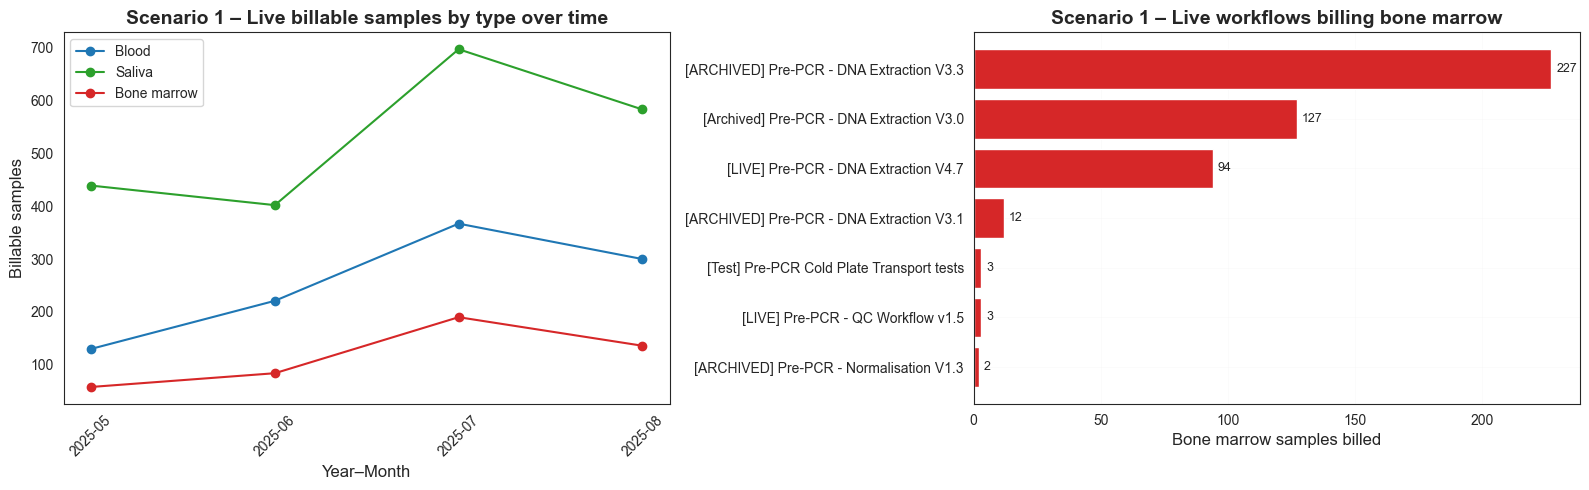

In [50]:
# Scenario 1 – Deep dive visuals: sample types and workflows

if 'billable_live' not in locals() or billable_live.empty:
    print("Run Scenario 1 cells first.")
else:
    color_blood = "#1f77b4"
    color_saliva = "#2ca02c"
    color_bm = "#d62728"  # bone marrow

    billable_live_ext = billable_live.copy()
    billable_live_ext["YEAR_MONTH"] = billable_live_ext["TIMESTAMP"].dt.to_period("M")

    # 1) Monthly volume by sample type (blood / saliva / bone marrow)
    type_monthly = (
        billable_live_ext[billable_live_ext["SAMPLE_TYPE"].isin(["blood", "saliva", "bone marrow"])]
        .groupby(["YEAR_MONTH", "SAMPLE_TYPE"])  # only main types
        .size()
        .unstack(fill_value=0)
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Left: lines per sample type
    tm_plot = type_monthly.copy()
    tm_plot.index = tm_plot.index.astype(str)
    if "blood" in tm_plot.columns:
        axes[0].plot(tm_plot.index, tm_plot["blood"], marker="o", color=color_blood, label="Blood")
    if "saliva" in tm_plot.columns:
        axes[0].plot(tm_plot.index, tm_plot["saliva"], marker="o", color=color_saliva, label="Saliva")
    if "bone marrow" in tm_plot.columns:
        axes[0].plot(tm_plot.index, tm_plot["bone marrow"], marker="o", color=color_bm, label="Bone marrow")
    axes[0].set_title("Scenario 1 – Live billable samples by type over time")
    axes[0].set_xlabel("Year–Month")
    axes[0].set_ylabel("Billable samples")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].legend()
    axes[0].grid(False)

    # 2) Top live workflows by bone marrow volume (to show root cause)
    bm_only = billable_live_ext[billable_live_ext["SAMPLE_TYPE"] == "bone marrow"]
    top_wf_bm = (
        bm_only["WORKFLOW_NAME"].value_counts().head(8).sort_values()
    )  # bottom-up for horizontal bar

    axes[1].barh(top_wf_bm.index, top_wf_bm.values, color=color_bm)
    axes[1].set_title("Scenario 1 – Live workflows billing bone marrow")
    axes[1].set_xlabel("Bone marrow samples billed")
    for y, v in enumerate(top_wf_bm.values):
        axes[1].text(v + 2, y, str(v), va="center", fontsize=9)

    plt.tight_layout()
    plt.show()


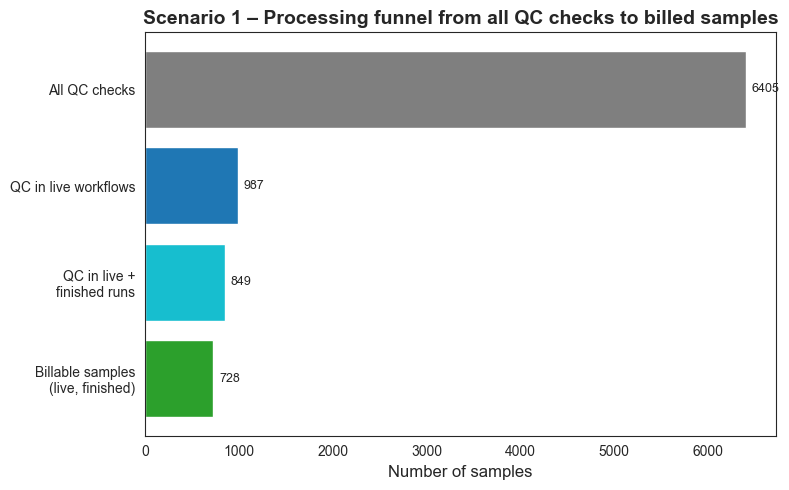

In [51]:
# Scenario 1 – Funnel: from all QC checks to billed live samples

# Build a simple funnel across ALL environments to show why live/billable matters

stages = []
counts = []
colors = ["#7f7f7f", "#1f77b4", "#17becf", "#2ca02c"]

# Stage 1: all QC checks
stages.append("All QC checks")
counts.append(len(df_checks))

# Stage 2: QC checks in LIVE workflows
checks_live_all = df_checks[df_checks["ENVIRONMENT"] == "live"]
stages.append("QC in live workflows")
counts.append(len(checks_live_all))

# Stage 3: QC checks in LIVE + FINISHED runs
runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"]
checks_live_runs = checks_live_all.merge(
    runs_live[["ID", "OUTCOME"]], left_on="RUN_ID", right_on="ID", how="inner"
)
checks_live_finished = checks_live_runs[checks_live_runs["OUTCOME"] == "finished"]
stages.append("QC in live +\nfinished runs")
counts.append(len(checks_live_finished))

# Stage 4: Billable (pass/NaN QC) in LIVE + FINISHED runs
billable_funnel = checks_live_finished[
    (checks_live_finished["QC_CHECK"].isna())
    | (checks_live_finished["QC_CHECK"] == "pass")
]
stages.append("Billable samples\n(live, finished)")
counts.append(len(billable_funnel))

fig, ax = plt.subplots(figsize=(8, 5))
y_pos = np.arange(len(stages))

ax.barh(y_pos, counts, color=colors[: len(stages)])
ax.set_yticks(y_pos)
ax.set_yticklabels(stages)
ax.invert_yaxis()
ax.set_xlabel("Number of samples")
ax.set_title("Scenario 1 – Processing funnel from all QC checks to billed samples")

for i, v in enumerate(counts):
    ax.text(v + max(counts) * 0.01, i, f"{v}", va="center", fontsize=9)

ax.grid(False)
plt.tight_layout()
plt.show()


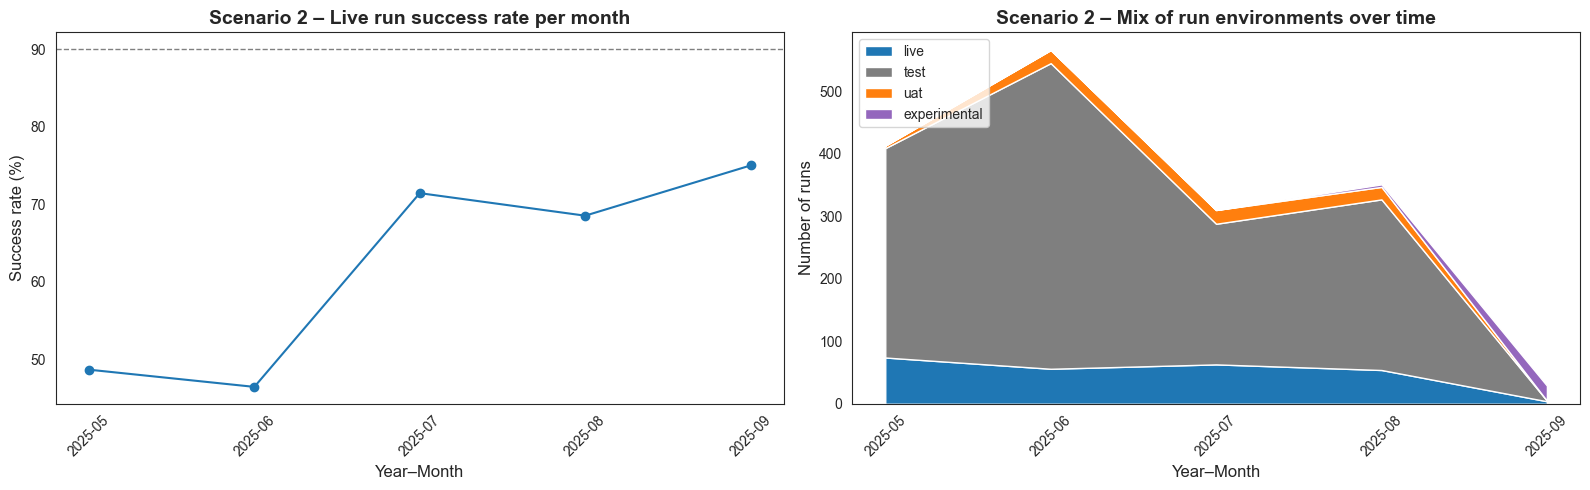

In [52]:
# Scenario 2 – Additional visuals: success rate and environment mix

# 1) Success rate per month for LIVE runs

runs_live_ext = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
runs_live_ext["YEAR_MONTH"] = runs_live_ext["START_TIME"].dt.to_period("M")

monthly_runs = runs_live_ext.groupby("YEAR_MONTH").agg(
    TOTAL_RUNS=("ID", "count"),
    FINISHED_RUNS=("OUTCOME", lambda s: (s == "finished").sum()),
)
monthly_runs["SUCCESS_RATE"] = (
    monthly_runs["FINISHED_RUNS"] / monthly_runs["TOTAL_RUNS"] * 100
)

mr_plot = monthly_runs.reset_index().copy()
mr_plot["YEAR_MONTH_STR"] = mr_plot["YEAR_MONTH"].astype(str)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(
    mr_plot["YEAR_MONTH_STR"],
    mr_plot["SUCCESS_RATE"],
    marker="o",
    color="#1f77b4",
)
axes[0].axhline(y=90, color="gray", linestyle="--", linewidth=1)
axes[0].set_title("Scenario 2 – Live run success rate per month")
axes[0].set_xlabel("Year–Month")
axes[0].set_ylabel("Success rate (%)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(False)

# 2) Environment mix of runs over time (stacked bar)

runs_env = df_runs.copy()
runs_env["YEAR_MONTH"] = runs_env["START_TIME"].dt.to_period("M")

env_monthly = runs_env.groupby(["YEAR_MONTH", "ENVIRONMENT"]).size().unstack(fill_value=0)

em_plot = env_monthly.reset_index().copy()
em_plot["YEAR_MONTH_STR"] = em_plot["YEAR_MONTH"].astype(str)

axes[1].stackplot(
    em_plot["YEAR_MONTH_STR"],
    [
        em_plot.get("live", 0),
        em_plot.get("test", 0),
        em_plot.get("uat", 0),
        em_plot.get("experimental", 0),
    ],
    labels=["live", "test", "uat", "experimental"],
    colors=["#1f77b4", "#7f7f7f", "#ff7f0e", "#9467bd"],
)
axes[1].set_title("Scenario 2 – Mix of run environments over time")
axes[1].set_xlabel("Year–Month")
axes[1].set_ylabel("Number of runs")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(loc="upper left")
axes[1].grid(False)

plt.tight_layout()
plt.show()
